## Generate latent and training neural dynamics for Von Mises brain

### Create graphical model

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
from VonMisesFunctions import *
from plotutils import *

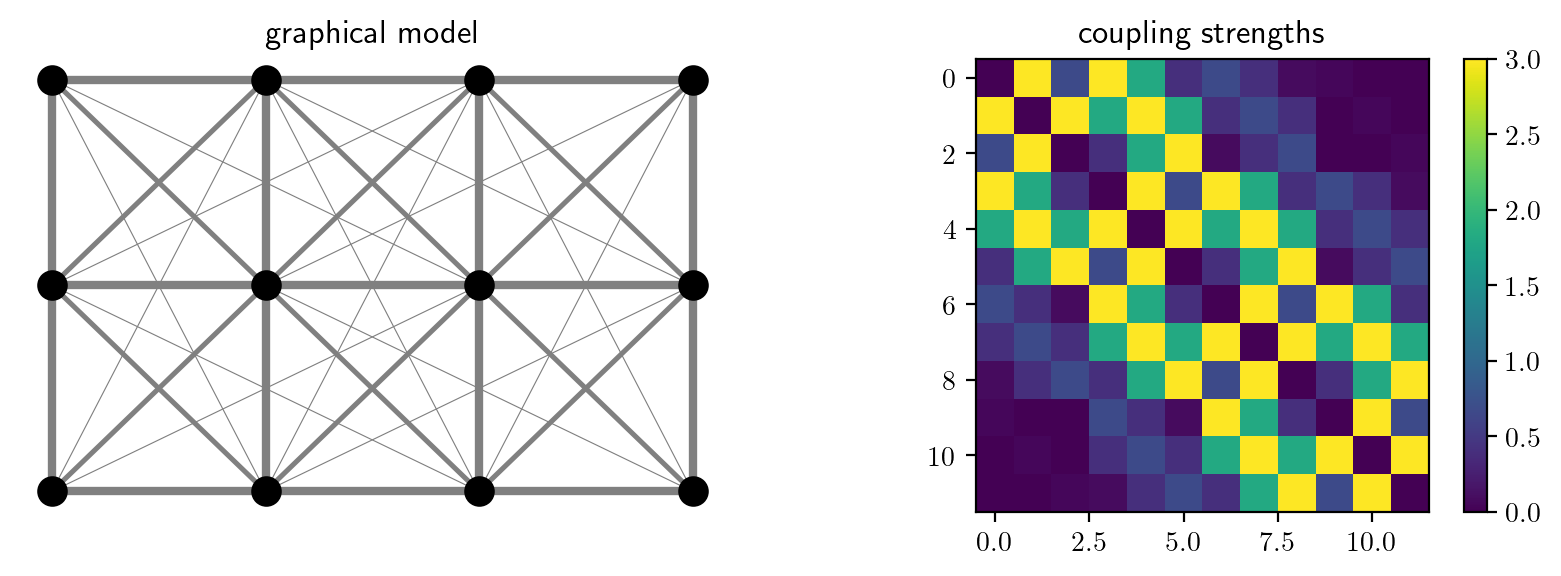

In [2]:
# create a grid structured graphical model
nrows, ncols = 4, 3
Ns = nrows*ncols # No. of variables

s_strength, c_spatial, c_strength, jitter = 0.5, 2, 3, 0 # singleton potential strength, pairwise coupling spatial scale, max interaction strength, jitter in coupling strength

KVec = 0.5 + s_strength*np.random.rand(Ns) # concentration parameters

J, node_positions = CreateGridGraphicalModel(nrows, ncols, c_spatial, c_strength, jitter)

AdjMat = (J[...,3] != 0)*1 # Adjacency matrix

DisplayGraphicalModel(J, node_positions,100)

### Generate input signal

Generate local orientation input at each node $\mu_s(t) \in [-\pi/2,\pi/2)$

In [3]:
B, T = 50, 30 # no. of batches, no. of time steps
T_low, T_high = 5, 10 # range of T_const = np. of time steps for which input is held constant

Mu = GenerateDynamicMu(Ns, B, T-1, T_low, T_high)

### Generate BP dynamics

In [4]:
K   = 30    # no. of discrete bins used to represent the belief of each variable
lam = 0.25  # relaxation parameter for BP dynamics

local_inputs, beliefs = [], []

for b in tqdm(range(B)):
    Phi = DiscreteSingletonPotentials(K, KVec, Mu[b])
    Psi = DiscretePairwisePotentials(K, Mu[b], J)
    local_inputs.append(Phi)
    beliefs.append(DiscreteBP(Phi, Psi, AdjMat, T, lam, None)[1])
    
    
local_inputs = np.array(local_inputs)
local_inputs = local_inputs/np.sum(local_inputs[:,:,:,None,:],axis=2) # normalize local potentials
beliefs = np.array(beliefs)

100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


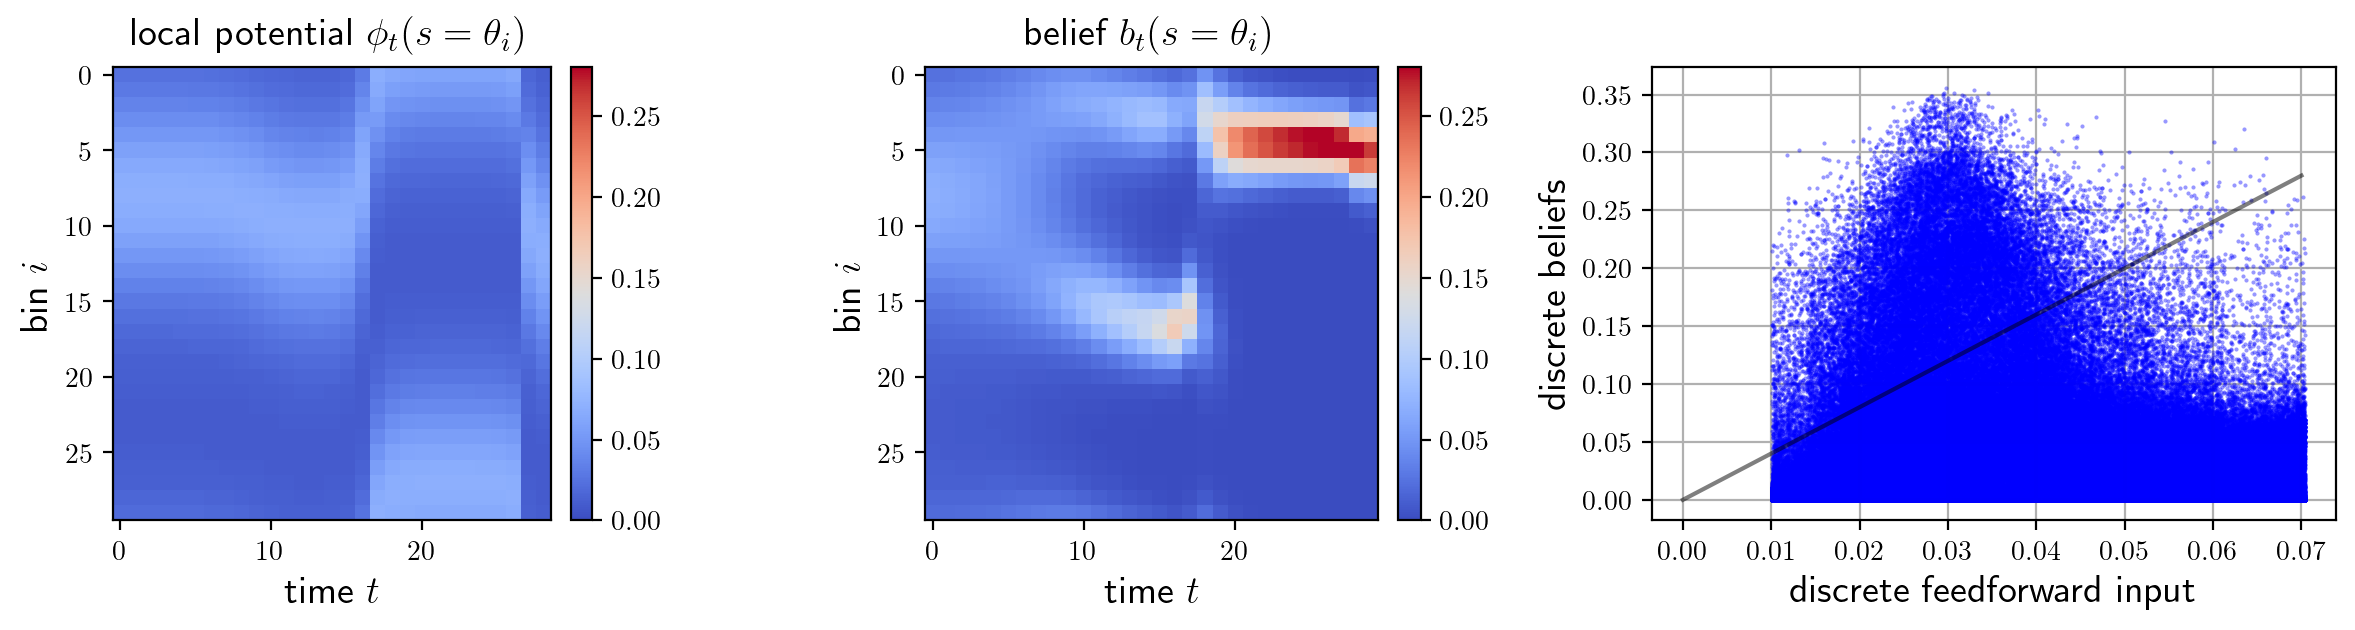

In [7]:
var, b = 5, 7
DisplayBeliefDynamics(var, b, local_inputs, beliefs)

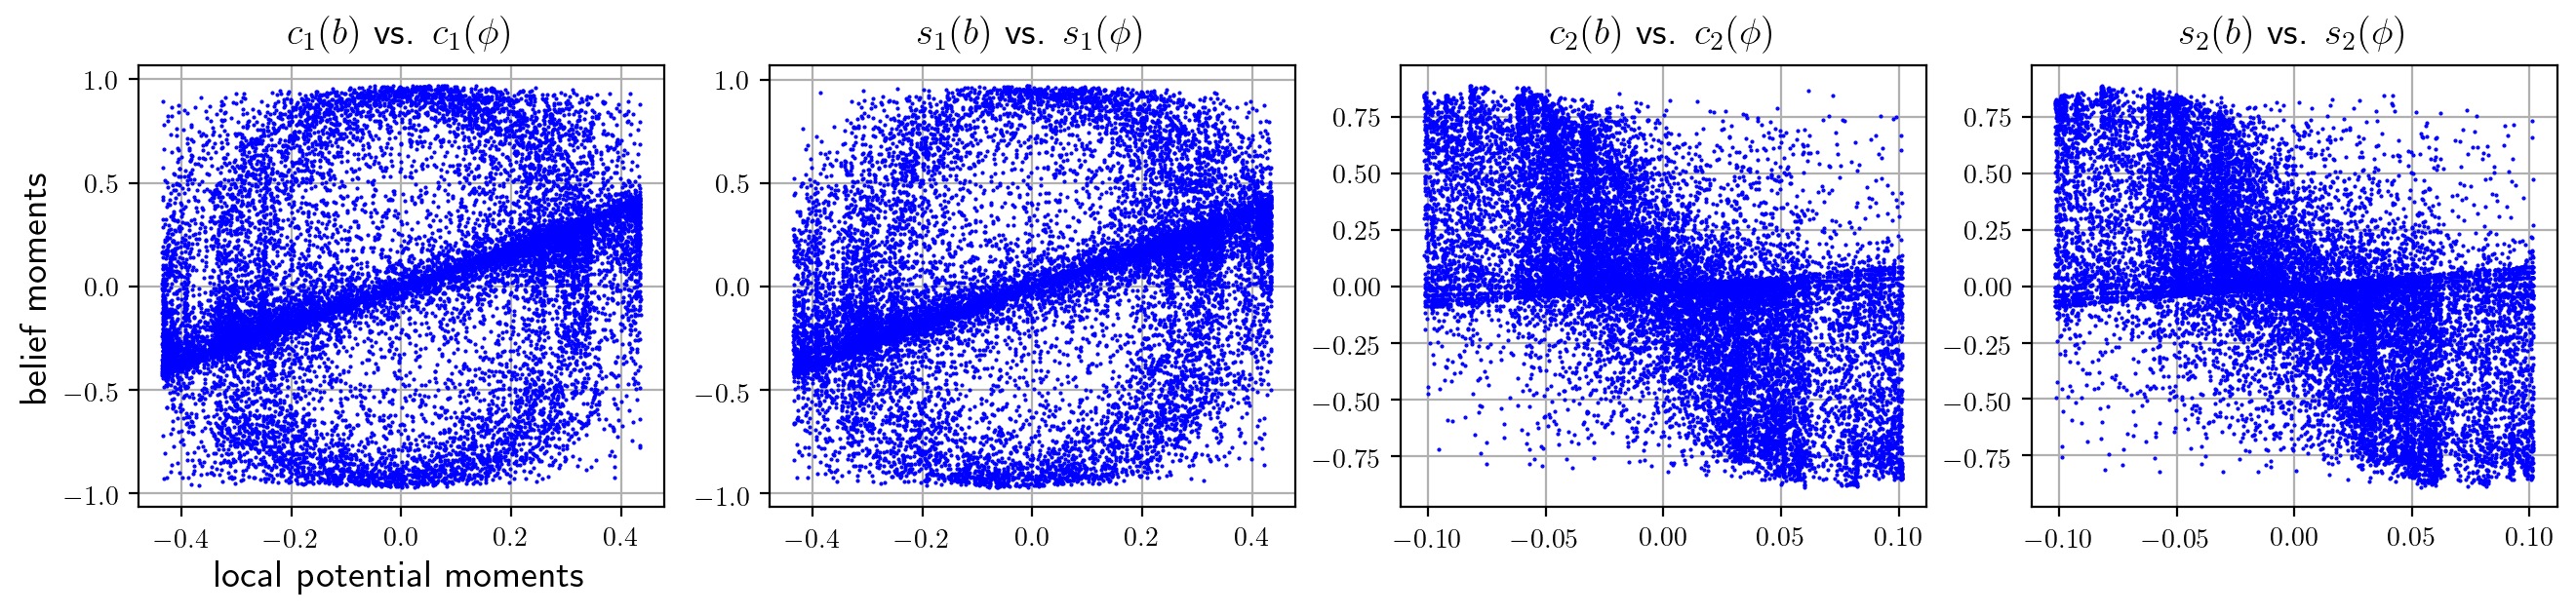

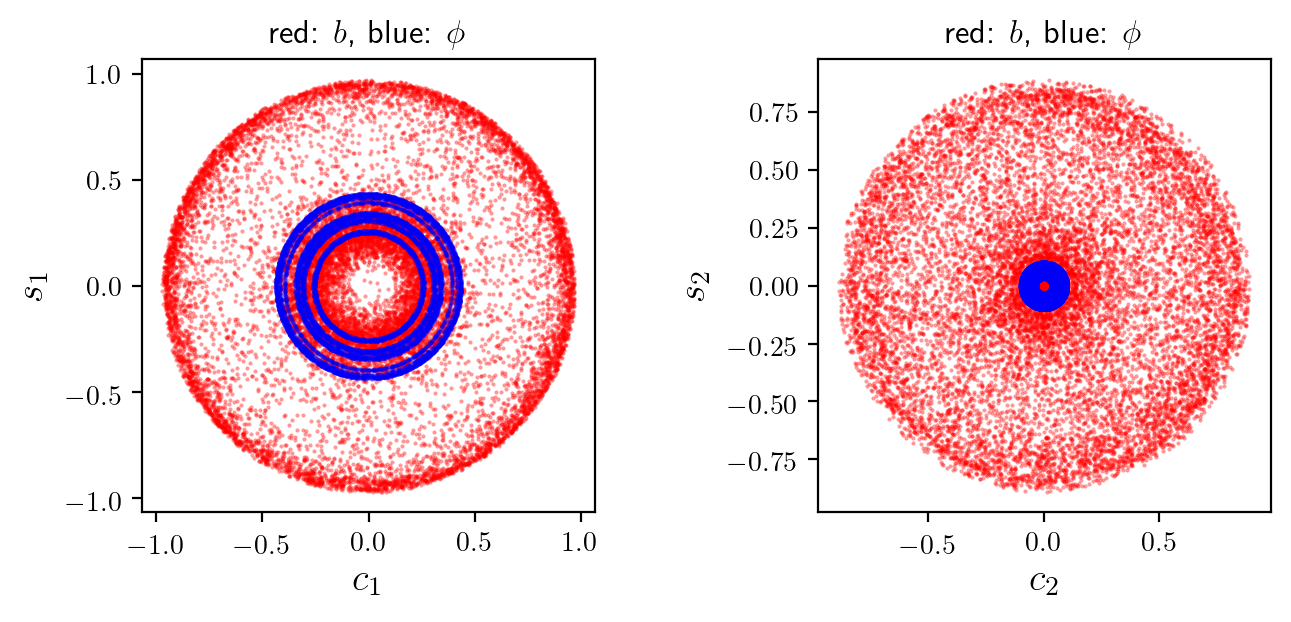

In [8]:
# Compute circular moments
l_cos2x, l_sin2x, l_cos4x, l_sin4x = ComputeCircularMoments(local_inputs, K)
b_cos2x, b_sin2x, b_cos4x, b_sin4x = ComputeCircularMoments(beliefs, K)

# Scatter plots of circular moments
DisplayCircularMoments1(local_inputs, beliefs, K)
DisplayCircularMoments2(local_inputs, beliefs, K)